# Speaker Diarization Using LSTM and GANMM on VoxConverse 2020 Dataset
Here we will be training an LSTM model for embedding generation. The MFCC features collected through 'Feature_Extraction_Training.ipynb' will be used as input data. These embeddings will further be clustered using spectral clustering and GANMM, the former being the state of the art mthord and the later being our varient to the speaker diarization problem. Finally, we will be testing both models in imbalanced data and compare the Diarization Error Rates(DERs).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Advanced\ ML\ project\ 2

/content/drive/MyDrive/Advanced ML project 2


## Loading libraries and importing packages




In [3]:
!pip3 install spectralcluster
!pip install tensorflow_addons 
!pip install pyannote.core
!pip install pyannote.metrics

     |████████████████████████████████| 686kB 7.0MB/s 
     |████████████████████████████████| 61kB 4.0MB/s 
     |████████████████████████████████| 133kB 9.2MB/s 
     |████████████████████████████████| 51kB 3.4MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 92kB 6.2MB/s 
  Found existing installation: click 8.0.0
    Uninstalling click-8.0.0:
      Successfully uninstalled click-8.0.0


In [4]:
%pylab inline
import io
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from pyannote.core import Annotation, Segment
from keras.utils.vis_utils import plot_model
from spectralcluster import SpectralClusterer
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score
from pyannote.metrics.diarization import DiarizationErrorRate

Populating the interactive namespace from numpy and matplotlib


## Loading data

In [5]:
X = np.load('./Data/MFCC_Features/Training/training_mfcc.npy') # mfcc features of dimension 40
y = np.load('./Data/MFCC_Features/Training/training_labels.npy') # true speaker labels of those feature vector

In [6]:
print(X.shape)
print(y.shape)

(52153, 32, 40)
(52153,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
def _map_sound(img, label):
    return (img, label)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset= train_dataset.batch(32)
train_dataset = train_dataset.map(_map_sound)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset= test_dataset.batch(32)
test_dataset = test_dataset.map(_map_sound)




## Model Architecture and Training


In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(768,  input_shape=(32,40), return_sequences=True))  # returns a sequence of vectors of dimension 768
model.add(layers.LSTM(768,return_sequences=True))  # returns a sequence of vectors of dimension 768
model.add(layers.LSTM(768))  # return a single vector of dimension 768
model.add(layers.Dense(256, activation='tanh')) 
model.add(layers.Dropout(0.01))
model.add(layers.Dense(256, activation=None))
model.add(layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))) # normalization for d vector embedding


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 32, 768)           2485248   
_________________________________________________________________
lstm_7 (LSTM)                (None, 32, 768)           4721664   
_________________________________________________________________
lstm_8 (LSTM)                (None, 768)               4721664   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               196864    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
lambda_2 (Lambda)            (None, 256)              

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(         # Use Stochastic gradient descent for optimizing the model
        learning_rate=0.003,momentum=0.05),
    loss=tfa.losses.TripletHardLoss())         # Use Triplet Hard Loss for making same speaker embeddings similar

In [ ]:
history = model.fit(train_dataset,epochs=20, validation_data=test_dataset)   # Training

Epoch 1/20
1304/1304 [==============================] - 47s 33ms/step - loss: 0.1110 - val_loss: 0.0949
Epoch 2/20
1304/1304 [==============================] - 42s 32ms/step - loss: 0.0918 - val_loss: 0.0896
Epoch 3/20
1304/1304 [==============================] - 42s 32ms/step - loss: 0.0884 - val_loss: 0.0903
Epoch 4/20
1304/1304 [==============================] - 42s 32ms/step - loss: 0.0864 - val_loss: 0.0899
Epoch 5/20
1304/1304 [==============================] - 41s 32ms/step - loss: 0.0842 - val_loss: 0.0864
Epoch 6/20
1304/1304 [==============================] - 41s 32ms/step - loss: 0.0826 - val_loss: 0.0860
Epoch 7/20
1304/1304 [==============================] - 42s 32ms/step - loss: 0.0805 - val_loss: 0.0853
Epoch 8/20
1304/1304 [==============================] - 41s 32ms/step - loss: 0.0790 - val_loss: 0.0863
Epoch 9/20
1304/1304 [==============================] - 42s 32ms/step - loss: 0.0775 - val_loss: 0.0847
Epoch 10/20
1304/1304 [==============================] - 41s 32m

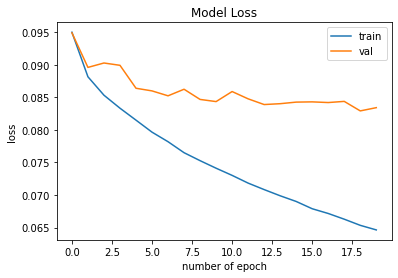

In [ ]:
plt.plot(history.history['loss'])              # Plotting the train and validation loss accross epochs to analyze performance change
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('number of epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model.save('./saved models/temp.h5')

In [8]:
model = tf.keras.models.load_model('./saved models/lstm_embeddings_model_1.h5')  # Loading previously saved model

In [9]:
model.evaluate(X_train,y_train)       
model.evaluate(X_test,y_test)

326/326 [==============================] - 3s 9ms/step - loss: 0.0821


0.08207554370164871

## Testing the model



In [10]:
def load_test_file(x_loc, y_loc, time_stamp_loc):
    X_test_us = np.load(x_loc) # mfcc features of dimension 20
    y_test_us = np.load(y_loc) # true speaker labels of those feature vector
    time_stamp_us = np.load(time_stamp_loc) # true speaker labels of those feature vector
    return (X_test_us, y_test_us, time_stamp_us)

In [27]:
def plot_scatter_embedding(embedding_2d, y_label, graph_title):   # For plotting 2D graph of embeddings
    a=[]
    b=[]
    colors = ['blue','red','green','pink','brown','black']
    color_list = []
    for i in range(embedding_2d.shape[0]):
      a.append(embedding_2d[i][0])
      color_list.append(colors[y_label[i]])
    for i in range(embedding_2d.shape[0]):
      b.append(embedding_2d[i][1])
    plt.scatter(a,b,color = color_list)
    plt.title(graph_title)
    plt.show()


def make_spectral_clusters(test_d_vector_embedding_us):          # Returns predictd values from spectral clustering of the embeddings

    clusterer = SpectralClusterer(
        min_clusters=2,
        max_clusters=6,
        p_percentile=0.90,
        gaussian_blur_sigma=0.0)
    y_test_pred_spectral_us = clusterer.predict(test_d_vector_embedding_us)
    return y_test_pred_spectral_us

In [28]:
def resegment(y_test_pred_spectral_us):             # Resegmentation of the predicted values for better accuracy
    i=2
    y1=[]
    y1.append(y_test_pred_spectral_us[0])
    y1.append(y_test_pred_spectral_us[1])
    for label_ in y_test_pred_spectral_us:
      if(i>=len(y_test_pred_spectral_us)-3):
        break
      if y_test_pred_spectral_us[i-2]==y_test_pred_spectral_us[i-1] and y_test_pred_spectral_us[i-1]==y_test_pred_spectral_us[i+1] and y_test_pred_spectral_us[i+1]==y_test_pred_spectral_us[i+2]:
        y1.append(y_test_pred_spectral_us[i-1])   # Changing the sandwitched value for reasonable predictions
      else:
        y1.append(y_test_pred_spectral_us[i])
      i=i+1

    y1.append(y_test_pred_spectral_us[len(y_test_pred_spectral_us)-3])
    y1.append(y_test_pred_spectral_us[len(y_test_pred_spectral_us)-2])
    y1.append(y_test_pred_spectral_us[len(y_test_pred_spectral_us)-1])
    return y1

In [41]:
def der_calculation(reference, hypothesis):                   # Calculating Diarization Error Rate
  from pyannote.metrics.diarization import DiarizationErrorRate
  diarizationErrorRate = DiarizationErrorRate()
  print("DER = {0:.3f}".format(diarizationErrorRate(reference, hypothesis, uem=Segment(0, 600))))
  print(diarizationErrorRate.optimal_mapping(reference, hypothesis))
  print(diarizationErrorRate(reference, hypothesis, detailed=True, uem=Segment(0, 600)))

def pyannote_graph(speaker_dictionary, time_stamp, y_label):   # For plotting timelines
    reference = Annotation()
    speaker_dict_true= speaker_dictionary
    for i in range(time_stamp.shape[0]):
      reference[Segment(time_stamp[i][0], time_stamp[i][1])]= speaker_dict_true[ y_label[i]]
    return reference


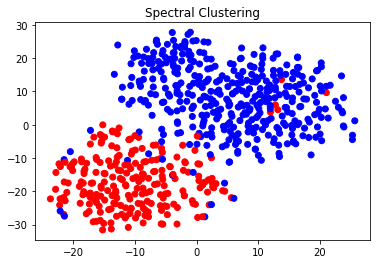

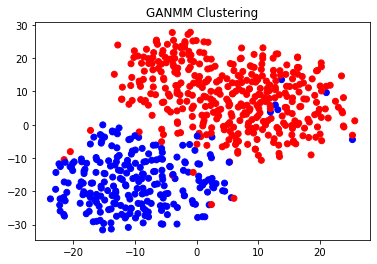

Using Spectral Clustering
DER = 0.071
{'a': 'A', 'b': 'B'}
{'missed detection': 33.88000000000012, 'false alarm': 1.3800000000000563, 'confusion': 9.280000000000044, 'correct': 584.8399999999999, 'total': 628.0000000000001, 'diarization error rate': 0.07092356687898123}

Using GANMM Clustering
DER = 0.068
{'a': 'B', 'b': 'A'}
{'missed detection': 33.88000000000012, 'false alarm': 1.3800000000000563, 'confusion': 7.1800000000001205, 'correct': 586.9399999999998, 'total': 628.0000000000001, 'diarization error rate': 0.06757961783439537}


In [49]:
# file = 'ycxxe.wav'
# file = 'zrlyl.wav'     #Scope to impove clustering using GANMM
file = 'yuzyu.wav'  #Very good der

X_test = np.load('./Data/MFCC_Features/Testing/Testing MFCC/test_mfcc_'+file+'.npy')
est_timestamps = np.load('./Data/MFCC_Features/Testing/Testing Est Timestamps/est_timestamps_'+file+'.npy')
true_labels = np.load('./Data/MFCC_Features/Testing/Testing True Labels/true_labels_'+file+'.npy')
true_timestamps = np.load('./Data/MFCC_Features/Testing/Testing True Timestamps/true_timestamps_'+file+'.npy')


embeddings_test = model.predict(X_test)
# print(X_test.shape)
y_pred_spectral = make_spectral_clusters(embeddings_test)
y1_pred_spectral = resegment(y_pred_spectral)

y_pred_ganmm = np.load('./GANMM preds/'+file.split('.')[0]+'.npy')
y1_pred_ganmm = resegment(y_pred_ganmm)


embedding_test_2d = TSNE(n_components=2).fit_transform(embeddings_test)
plot_scatter_embedding(embedding_test_2d, y1_pred_spectral, "Spectral Clustering")
plot_scatter_embedding(embedding_test_2d,y1_pred_ganmm,"GANMM Clustering")

speaker_dict_true={}
speaker_dict_hypo_spectral = {}
speaker_dict_hypo_ganmm = {}


for i in range(1,len(set(true_labels.tolist()))+1):
  speaker_dict_true[i] = chr(ord('A')+i-1)

for i in range(len(set(y1_pred_spectral))):
  speaker_dict_hypo_spectral[i] = chr(ord('a')+i)

for i in range(len(set(y1_pred_ganmm))):
  speaker_dict_hypo_ganmm[i] = chr(ord('a')+i)


reference= pyannote_graph(speaker_dict_true, true_timestamps, true_labels)       # Getting the actual timeline of speakers
hypothesis_spectral= pyannote_graph(speaker_dict_hypo_spectral, est_timestamps, y1_pred_spectral)         # Getting the predicted timeline of speakers
hypothesis_ganmm = pyannote_graph(speaker_dict_hypo_ganmm, est_timestamps, y1_pred_ganmm)
print("Using Spectral Clustering")
der_calculation(reference, hypothesis_spectral)
print("\nUsing GANMM Clustering")
der_calculation(reference, hypothesis_ganmm)                            # Calculating DER

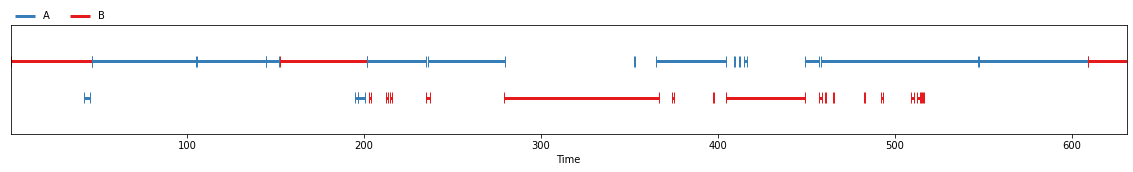

In [45]:
reference

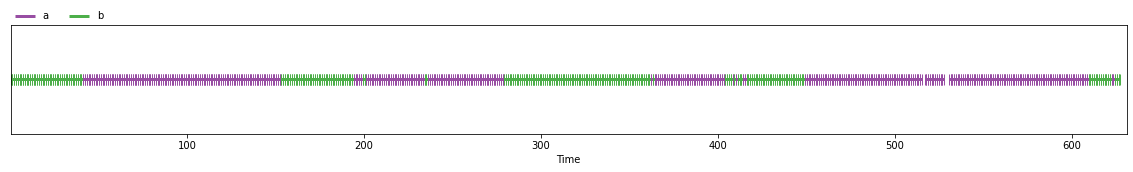

In [46]:
hypothesis_spectral

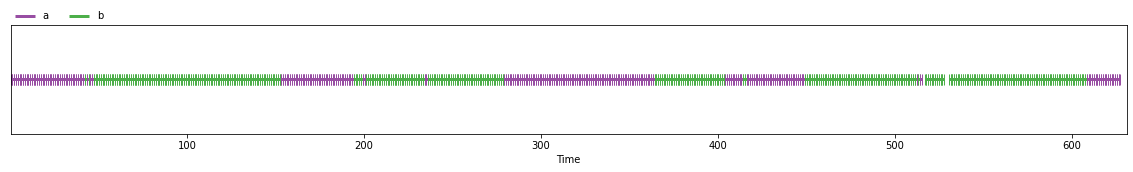

In [47]:
hypothesis_ganmm